In [ ]:
# %%

import os
import json
from langchain_openai import AzureChatOpenAI
import openai
import random
with open("backup_config.json") as config_file:
    config = json.load(config_file)

os.environ["AZURE_OPENAI_API_KEY"] = config["SECRET_KEY_OPENAI"]
os.environ["AZURE_OPENAI_ENDPOINT"] = config["BASE_URL"]
os.environ["AZURE_OPENAI_API_VERSION"] = "2023-05-15"
os.environ["OPENAI_API_TYPE"] = "azure"
os.environ["TAVILY_API_KEY"] = config["TAVILY_API_KEY"]

llm = AzureChatOpenAI(
        deployment_name="gpt-35-turbo", 
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
        openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
        openai_api_key=os.environ["AZURE_OPENAI_API_KEY"],
        model_name="gpt-35-turbo" 
    )

In [ ]:
# %%

from langchain_community.graphs import Neo4jGraph

os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "abc123456"

In [ ]:
# %%

stage_dict = {
    1:[2,3,4,5],
}

In [ ]:
# %%

# user_prompt_template = """System prompt: This is the structure of the whole story [graph, defined
# by the author], currently it is in [stage 2], you should follow these
# components:
# event: 来自当前阶段用户定义的卡片的内容
# character: 来自当前阶段用户定义的卡片的内容
# the player's input: 来自当前阶段用户定义的卡片的内容
# You should output the narrative...."""

In [ ]:
# %%

def read_file_to_string(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    return content

In [ ]:
# %%

# file_path = 'stage1.txt'
# file_content = read_file_to_string(file_path)
# print(file_content)

In [ ]:
# %%

# def generate_prompt(curr_input, prompt_lib_file): 
#   """
#   Takes in the current input (e.g. comment that you want to classifiy) and 
#   the path to a prompt file. The prompt file contains the raw str prompt that
#   will be used, which contains the following substr: !<INPUT>! -- this 
#   function replaces this substr with the actual curr_input to produce the 
#   final promopt that will be sent to the GPT3 server. 
#   ARGS:
#     curr_input: the input we want to feed in (IF THERE ARE MORE THAN ONE
#                 INPUT, THIS CAN BE A LIST.)
#     prompt_lib_file: the path to the promopt file. 
#   RETURNS: 
#     a str prompt that will be sent to OpenAI's GPT server.  
#   """
#   if type(curr_input) == type("string"): 
#     curr_input = [curr_input]
#   curr_input = [str(i) for i in curr_input]

#   f = open(prompt_lib_file, "r")
#   prompt = f.read()
#   f.close()
#   for count, i in enumerate(curr_input):   
#     prompt = prompt.replace(f"!<INPUT {count}>!", i)
#   if "<commentblockmarker>###</commentblockmarker>" in prompt: 
#     prompt = prompt.split("<commentblockmarker>###</commentblockmarker>")[1]
#   return prompt.strip()

# prompt = generate_prompt(file_content,r'C:\Users\user\Desktop\UROP2100M\Stanford_AItown\reverie\backend_server\persona\prompt_template\v3_ChatGPT\get_entity.txt' )

In [ ]:
# %%

import pprint as pprint
# pprint.pprint(prompt)

In [ ]:
# %%

from typing import Annotated, Literal

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, BaseMessage, ToolMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict
from langchain_core.tools import tool
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain.chains import GraphCypherQAChain
from langchain_core.prompts.prompt import PromptTemplate
from langgraph.checkpoint.sqlite import SqliteSaver

In [ ]:
#%%

graph = Neo4jGraph()
graph.query("MATCH (n) DETACH DELETE n")
class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    custom_ouput: bool

class OutputbyUser(BaseModel):
    """
    Represents the output generated by a user during a paused step in the graph.

    The `OutputbyUser` class allows users to pause the graph and provide their input.
    It captures the user's request and stores it as the `request` attribute.

    Attributes:
        request (str): The request made by the user during the paused step.

    """
    request: str

class Graphretriever:
    def __init__(self, docs ,graph_docs, graph):
        self._graph_docs = graph_docs 
        self._docs = docs
        self._graph = graph

    @classmethod
    def from_docs(cls, docs,graph):
        docs = [Document(page_content=docs)]
        llm_transformer = LLMGraphTransformer(llm=llm,
                                              allowed_nodes=["Entity", "Location","Items",'Time'],
    allowed_relationships=["HAVE_USED", "LOCATED_IN", "WORKED_AT", "SPOUSE", 'FRIEND', "ENEMY", "MENTOR", "LIKE", "LOVE", "DISLIKE", "HAVE_SEEN", 'HAVE_CREATE', "IS_BORNED",
                           'HAS_DIE', 'PET', "HAVE_BUILDING","INSIDE", "HAS_MADE", 'HAS', 'Has_FACILITY'],
    node_properties=["born_year", 'dead_year', 'married_year', 'time_start_work', "build_time", "first_appear_time", 'country', 
                     'function', 'creator', 'event_in'],)
        graph_docs = llm_transformer.convert_to_graph_documents(docs)
        graph.add_graph_documents(graph_docs)
        graph.refresh_schema()
        return cls(docs,graph_docs, graph)

    def query(self, query: str):
        chain = GraphCypherQAChain.from_llm(
            llm, graph=self._graph, verbose=True,
                )
        return chain
    def update_graph(self, text: str):
        docs = [Document(page_content=text)]
        llm_transformer = LLMGraphTransformer(llm=llm,
                                              allowed_nodes=["Entity", "Location","Items",'Time'],
    allowed_relationships=["HAVE_USED", "LOCATED_IN", "WORKED_AT", "SPOUSE", 'FRIEND', "ENEMY", "MENTOR", "LIKE", "LOVE", "DISLIKE", "HAVE_SEEN", 'HAVE_CREATE', "IS_BORNED",
                           'HAS_DIE', 'PET', "HAVE_BUILDING","INSIDE", "HAS_MADE", 'HAS', 'Has_FACILITY'],
    node_properties=["born_year", 'dead_year', 'married_year', 'time_start_work', "build_time", "first_appear_time", 'country', 
                     'function', 'creator', 'event_in'],)
        graph_docs = llm_transformer.convert_to_graph_documents(docs)
        graph.add_graph_documents(graph_docs)
        graph.refresh_schema()
        return self._graph

@tool
def documentLookup(arg: str):
    """
    Perform a lookup in the graph of relationships with entities such as events, people, places, and objects.

    The function takes a query string as input and searches for relevant information in the graph.
    It uses the `retriever` object to execute the query and retrieve the desired results.

    """
    
    test_prompt = '''MATCH (n)-[r]-(m) return n,r,m'''
    graph_query_result = graph.query(test_prompt)
    print(f'{graph_query_result=}')
    return graph_query_result

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

tavily = TavilySearchResults(max_results=2)
tavily = [tavily]
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tavily +[ OutputbyUser, documentLookup])

In [ ]:
# %%

def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    custom_ouput = False
    print(f'{response.tool_calls}')
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == OutputbyUser.__name__
    ):
        custom_ouput = True
    return {"messages": [response], "custom_ouput": custom_ouput}

def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if state["custom_ouput"]:
        return 'human'
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

In [ ]:
# %%

graph_builder = StateGraph(State)
tool_node = BasicToolNode(tools=tavily + [documentLookup])
graph_builder.add_node("tools", tool_node)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge("__start__", "chatbot")

In [ ]:
# %%

def create_response(response: str, ai_message: AIMessage):
    for tool_call in ai_message.tool_calls:
        if tool_call["name"] == OutputbyUser.__name__:
            return ToolMessage(
                content=response,
                tool_call_id=tool_call["id"],
            )

In [ ]:
# %%

def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }

In [ ]:
# %%

graph_builder.add_node("human", human_node)

In [ ]:
# %%

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", "human": "human", "__end__": "__end__"},
)

In [ ]:
# %%

memory = SqliteSaver.from_conn_string(":memory:")

In [ ]:
# %%

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
state_graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

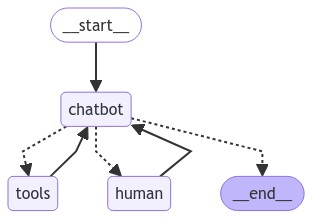

In [ ]:
# %%

from IPython.display import Image, display

try:
    display(Image(state_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# %%

config = {"configurable": {"thread_id": "1"}}
def ask_graph(user_input):
    # The config is the **second positional argument** to stream() or invoke()!
    events = state_graph.stream(
        {"messages": [("user", user_input)]}, {"configurable": {"thread_id": "1"}}, stream_mode="values"
    )
    messages_store = []
    for event in events:
        if "messages" in event:
            event["messages"][-1].pretty_print()
            messages_store.append(event["messages"][-1])

    return messages_store
user_input = "show all the node that the undersea cities node point to.That is return the node that undersea cities node have outward edges on it."

In [ ]:
#%%

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma
from langchain_openai import AzureOpenAIEmbeddings


# Initialize Azure OpenAI embeddings and load the contents of the file 'stage1.txt' into a Document object
# The Document object contains the text of the state of the union which is used to build the graph's index
# The Graphretriever is initialized with the state of the union text and the graph which is used to query the graph database
embd = AzureOpenAIEmbeddings()
with open('test1.txt', 'r') as f:
    file_content = f.read()

doc = [Document(page_content=file_content)]
graph_api = Graphretriever.from_docs( '',graph) # Initialize the graph API with the state of the union text and the graph

In [ ]:
# %%

# initialize the doc system
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(doc)

# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embd,
)
retriever = vectorstore.as_retriever()

In [ ]:
# %%

### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

In [ ]:
# %%

### Retrieval Grader


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "marval ironman"
docs = retriever.get_relevant_documents(question)
# doc_txt = docs[1].page_content

In [ ]:
# %%

### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

question = 'who is Paul?'
# Prompt
prompt = hub.pull("rlm/rag-prompt")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
# print(generation)

In [ ]:
# %%

### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
# hallucination_grader.invoke({"documents": docs, "generation": generation})

In [ ]:
# %%

### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
# answer_grader.invoke({"question": question, "generation": generation})

In [ ]:
# %%

### Answer Merger


# Data model
class GenerationMerger(BaseModel):
    """Merge the generation from rag and graph rag."""

    merged_content: str = Field(
        description="Merge the content from the RAG and the Graph RAG generation. You need to combine the similiar and the unique content of the two text  \n outputing a coherent text. You only need to output the merged content."
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GenerationMerger)

# Prompt
system = """You are a content merger merging the generation from rag and graph rag.Graph rag tend to hold more marco and long-term information. While RAG tends to hold mirco and short-term information.Try to usen the graph rag info for background and fill in the detail with rag.
if graph rag generation said there is no information, only generate text based on rag generation instead."""
merge_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Graph RAG generation: \n\n {graph_generation} \n\n RAG generation: {generation}"),
    ]
)

generation_merger = merge_prompt | structured_llm_grader

In [ ]:
# %%

### Question Re-writer

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
# question_rewriter.invoke({"question": question})

In [ ]:
# %%

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    merge_final : str 
    question: str
    generation: str
    graph_generation : str
    documents: List[str]
    retry: int

In [ ]:
# %%

from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}



def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}
def graph_generate(state):
    question = state["question"]
    documents = state["documents"]
    graph_generation = ask_graph(question)
    graph_generation = graph_generation[-1].content
    return {"graph_generation" : graph_generation,"documents": documents, "question": question}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question, 'retry': state['retry']}

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question , 'retry': state['retry'] + 1}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = tavily[0].invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    filtered_documents = state["documents"]
    generation = state["generation"]
    retry = state['retry']


    if not filtered_documents and retry < 2:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    elif retry == 2:
        print(f"---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION AFTER {retry} ATTEMPTS, End Session---")
        return "end_session"
    elif generation == '':
        print("---DECISION: GENERATE_GRAPH---")
        return 'generate_graph'
    else:
        # We have relevant documents and we have generated from graph, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
  

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )

    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [ ]:
# %% 

def merge_text(state):
    print('---MERGE TEXT---')
    generation = state["generation"]
    graph_generation = state['graph_generation']
    merge_final = state['merge_final']
    document = state['documents']

    merged_text = generation_merger.invoke({"graph_generation": graph_generation, "generation": generation})

    return {'retry':state['retry'],"merge_final": merged_text.merged_content , "graph_generation": graph_generation , 'generation' : generation}

In [ ]:
# %%

from langgraph.graph import END, StateGraph, START

adaptive_rag = StateGraph(GraphState)

# Define the nodes
adaptive_rag.add_node("web_search", web_search)  # web search
adaptive_rag.add_node("retrieve", retrieve)  # retrieve
adaptive_rag.add_node("grade_documents", grade_documents)  # grade documents
adaptive_rag.add_node("generate", generate)  # generatae
adaptive_rag.add_node("transform_query", transform_query)  # transform_query
adaptive_rag.add_node('graph_generate', graph_generate)
adaptive_rag.add_node('merge_text', merge_text)


# Build graph
adaptive_rag.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
adaptive_rag.add_edge("web_search", "generate")
adaptive_rag.add_edge("retrieve", "grade_documents")
adaptive_rag.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate_graph": 'graph_generate',
        'generate': 'generate',
        'end_session': END
    },
)
adaptive_rag.add_edge('graph_generate', 'generate')
adaptive_rag.add_edge("transform_query", "retrieve")
adaptive_rag.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": 'merge_text',
        "not useful": "transform_query",
    },
)
adaptive_rag.add_edge('merge_text', END)

# Compile
ada_rag_complied = adaptive_rag.compile()

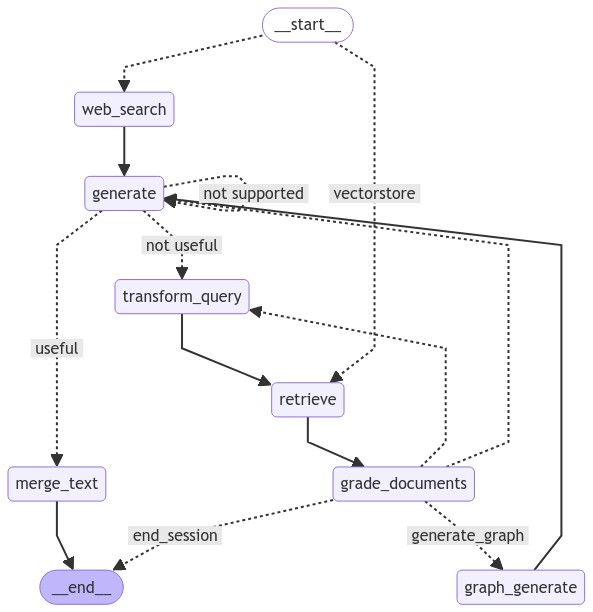

In [ ]:
# %%

from IPython.display import Image, display

try:
    display(Image(ada_rag_complied.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# %%

from pprint import pprint

inputs =  "base on the documents,what did human made in the future?"

def call_ada_rag_with_graph(user_input):
    user_inputs = {
    "question": user_input,
    'generation': '',
    'merge_final': '',
    'retry': 0
}
    output_store = None
    for output in ada_rag_complied.stream(user_inputs):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint("\n---\n")
        output_store = output
    return output

# temp_ata = call_ada_rag_with_graph(inputs)

In [ ]:
# %%

# pprint(temp_ata)

In [ ]:
# %%

def add_doc(path):
    with open(path) as f:
        content = f.read()
    doc.append(Document(page_content=content))
    graph_api.update_graph(content)
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(doc)

    # Add to vectorstore
    vectorstore = Chroma.from_documents(
        documents=doc_splits,
        collection_name="rag-chroma",
        embedding=embd,
    )
    return content

def add_doc_string(text):
    doc.append(Document(page_content=text))
    graph_api.update_graph(text)
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(doc)

    # Add to vectorstore
    vectorstore = Chroma.from_documents(
        documents=doc_splits,
        collection_name="rag-chroma",
        embedding=embd,
    )
    return text

In [ ]:
# %%

# Start from here, we have function ask graph and call_ada_rag_with_graph that
# let us do graph retrieval and do combined retrieval respectively.

In [ ]:
# %%

def reducer_append(old_list , new_string):
    print(f'{old_list=}')
    if new_string is not None:
        return old_list + [new_string]
    return old_list
class MainGraphState(TypedDict):
    world_setting : list
    user_input: list
    story_generation : list
    rag_generation : Annotated[list, reducer_append] 
    character_allocation : dict
    logic : list
    summary : list
    all_summary : str
    output : str

In [ ]:
# %%

def initizalize_graph_state_and_doc(state):
    """
    Initializes the graph state and document.

    This function takes in a state object and initializes the graph state by 
    extracting the world setting, character, narrator behavior, and previous 
    generation from the state. It then reads the all generation text from a file 
    and appends a document to the doc list. The function also updates the graph 
    using the graph API and splits the documents using a text splitter. Finally, 
    it adds the split documents to a vector store.

    Args:
        state (dict): The state object containing the graph state information.

    Returns:
        dict: An empty dictionary.
    """
    print('---initizalize_graph_state_and_doc---')
    world_setting = state['world_setting']
    previous_gen = None
    if state['story_generation'] != []:
        previous_gen = state['story_generation'][-1]
        print(f'{type(previous_gen)=}')
        print(f'{previous_gen=}')
        doc.append(Document(page_content=previous_gen))
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=500, chunk_overlap=0
        )
        doc_splits = text_splitter.split_documents(doc)
        add_doc_string(world_setting[-1])
        all_gen_text = '\n\n'.join(state['story_generation'])
        graph.query("MATCH (n) DETACH DELETE n")
        graph_api.update_graph(all_gen_text)
        vectorstore = Chroma.from_documents(
        documents=doc_splits,
        collection_name="rag-chroma",
        embedding=embd,
        )

    for ws in world_setting:
        graph_api.update_graph(ws)
    return {'world_setting': world_setting}

In [ ]:
# %%

# Prompt
system = """You are a quetion raiser who raise questions based on what is needed to answer the user given question. You questions need to be relevant to the user question.
Return your questions in json format and as many as you can. All questions need to be stored at 'questions' key.
"""
reflect_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question}. Your response in json need to have key questions."),
    ]
)

sub_question_chain = reflect_prompt | llm


question = "tell me a story that amy goes to deepsea adventure."

def ask_self_question(user_input):
    l_of_qs = json.loads(sub_question_chain.invoke({"question": user_input}).content)["questions"]
    return l_of_qs

In [ ]:
# %%

def get_relevant_info_from_docs(state):
    print('---get_relevant_info_from_docs---')
    user_input = state['user_input'][-1]
    l_of_q = []
    for i in range(3):
        try:
            l_of_q =ask_self_question(user_input)
            break
        except:
            continue
    relevant_info = []
    if l_of_q == []:
        graph_search = call_ada_rag_with_graph('Based on the document, '+user_input)
        if graph_search['retry'] <2:
            relevant_info.append(graph_search['merge_final'])
        else:
            relevant_info.append('')
    else:
        l_of_q.append(user_input)    
        for qs in l_of_q:
            graph_search = call_ada_rag_with_graph('Based on the document, '+qs)
            if graph_search['retry'] <2:
                relevant_info.append(graph_search['merge_final'])
            else:
                relevant_info.append('')
    print(f'{relevant_info=}')
    relevant_info_str = '||'.join(relevant_info)
    return {'rag_generation': relevant_info_str}

In [ ]:
# %%

class LogicChecker(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Later text contradict the earlier text? Answer 'yes: reason' or 'no: reason'."
    )


system = """You are a logical assistant who check if the later text content contradict the earlier text content.
Give a binary score with reason: 'yes : reason' or 'no : reason'. Yes' means that the later text contradict the earlier text. 
No means that the two text don't contradict each other. Also, change of place and time is allowed in two text.
"""
logic_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Earlier text: \n\n {text1}. Later text: \n\n {text2}."),
    ]
)

logic_chain = logic_prompt | llm


# text1 = "On monday. Mary is in the kitchen. Tom is in the bedroom."
# text2 = "On Tuesday.Tom is in the kitchen. Mary is in the bedroom."
# text1 = "On monday. Mary is a female. Tom is a male."
# text2 = "On Tuesday.Tom is a female. Mary is a male."
text1 = "Elephant 1 arrived"
text2 = "Elephant 2 arrived"
def check_two_texts(text1, text2):
    return logic_chain.invoke({"text1": text1, "text2": text2}).content

In [ ]:
# %%

def check_logic_generate(state):
    print('---check_logic_generate---')
    if state['story_generation'] == []:
        return {'logic': [True, [], []]}
    previous_gens = state['story_generation']
    logic = [True, [], []]
    for i in range(len(previous_gens)-1):
        text1 = previous_gens[i]
        text2 = previous_gens[-1]
        check_result = check_two_texts(text1, text2)
        if check_result[:3] == 'No:':
            logic[0] = False
            logic[1].append(i)
            logic[2].append(check_result[5:])
    print(f'{logic=}')
    return {'logic': logic}

In [ ]:
# %%

class CharacterTracker(BaseModel):
    """Binary score to assess answer addresses question."""

    grouping: str = Field(
        description="What is the grouping of the characters? e.g. 'group1 : Character1 , Character3' or 'group2 : Character2 , Character4'. Output in json format"
    )


system = """You are a character tracker who tracks the grouping of the characters based on the character location in the input text.
You output need to be in json format where groupi is the key. i is an integer. Name of charaters are the values in list.
"""
group_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Text: \n\n {text}."),
    ]
)

group_chain = group_prompt | llm


# text1 = "On monday. Mary is in the kitchen. Tom is in the bedroom."
# text2 = "On Tuesday.Tom is in the kitchen. Mary is in the bedroom."
# text1 = "On monday. Mary is a female. Tom is a male."
# text2 = "On Tuesday.Tom is a female. Mary is a male."
text = "In the heart of the Future Undersea Civilization, echoes of the past bubble up through the serene waters. Arial and Paul once thrived among the high-tech wonders, sharing dreams beneath the colossal transparent domes. The nostalgic hum of underwater transportation spoke their names. Luis and Jacob now walk the pathways they once charted, the memories of their friends lingering in the cool, aquatic air."
def check_group(text):
    return json.loads(group_chain.invoke({ "text": text}).content)

In [ ]:
#%%

def get_grouping(state):
    print('---get_grouping---')
    previous_gens = state['story_generation'][-1]
    character_allocation = state["character_allocation"]
    group = {}
    for i in range(3):
        try:
            group=check_group(previous_gens)
            break
        except:
            return {'character_allocation':character_allocation}
    character_pre_allocation = []
    chara_post_allocation = []
    for k, v in character_allocation.items():
        for c in v:
            character_pre_allocation.append((c, v.copy().remove(c)))
    for k,v in group.items():
        for c in v:
            chara_post_allocation.append(c)
    for c in character_pre_allocation:
        if c[0] not in chara_post_allocation:
            for k, v in group.items():
                breaked = False
                for sc in c[1]:
                    if sc in v:
                        v.append9(c[0])
                        break
                if breaked:
                    break
    print(f'{group=}')
    return {'character_allocation':group}

In [ ]:
# %%

system = """You are a summarizer who summarizes the input story stage.
"""
summarize_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Story stage: \n\n {text}."),
    ]
)

summarize_chain = summarize_prompt | llm


with open('stage1.txt', 'r') as f:
    user_input = f.read()

def summarize(user_input):
    summarized = summarize_chain.invoke({"text": user_input}).content
    return summarized

In [ ]:
# %%

def get_summary(state):
    print('---get_summary---')
    previous_gens = state['story_generation'][-1]
    summarized = summarize(previous_gens)
    all_sum = ''
    for i, sum in enumerate(state['summary']):
        all_sum += f'Stage{i}: \n'
        all_sum += sum
    all_sum  = summarize(all_sum)
    return {'summary': summarized, 'all_summary': all_sum}

In [ ]:
# %%

def merge_all(state):
    print('---merge_all---')
    rag_gen = state['rag_generation']
    char_allo = state['character_allocation']
    logic = state['logic']
    summary = state['all_summary']
    output = ''

    output += f'Information for next generatioin:\n {rag_gen} \n'
    output += f'Character allocation: \n {json.dumps(char_allo)} \n'
    output += f'Summary of what happened: \n {summary} \n'
    output += f'\n storyprogression should be slower, keep cohesive between history \n'
    return {'output': output}

In [ ]:
# %%

narrative_state_graph = StateGraph(MainGraphState)

narrative_state_graph.add_node('initlize', initizalize_graph_state_and_doc)
narrative_state_graph.add_node('get_info', get_relevant_info_from_docs)
narrative_state_graph.add_node('check_logic', check_logic_generate)
narrative_state_graph.add_node('group', get_grouping)
narrative_state_graph.add_node('summarize', get_summary)
narrative_state_graph.add_node('merge_all', merge_all)

narrative_state_graph.add_edge(START, "initlize")
narrative_state_graph.add_edge('initlize', "get_info")
narrative_state_graph.add_edge('get_info', "check_logic")
narrative_state_graph.add_edge('check_logic', "group")
narrative_state_graph.add_edge('group', "summarize")
narrative_state_graph.add_edge('summarize', "merge_all")
narrative_state_graph.add_edge('merge_all', END)
nar_complied = narrative_state_graph.compile()

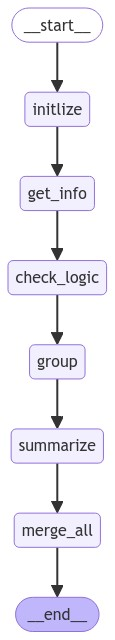

In [ ]:
# %%

from IPython.display import Image, display

try:
    display(Image(nar_complied.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# %%

def call_nar_graph(world_setting, user_input, story_generation,character_allocation, summary):
    user_inputs = {
        "world_setting": world_setting,
        "user_input": user_input,
        "story_generation": story_generation,
        "character_allocation": character_allocation,
        "summary": summary,
        'logic': [True, [], []],
    }
    output_store = None
    for output in nar_complied.stream(user_inputs, stream_mode= 'values'):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint("\n---\n")
        output_store = output
    return output_store

In [ ]:
# %%

# world_setting at least one, a list variable
ws = ['''

Humanity has developed an advanced undersea civilization in the future. Undersea cities have become the primary habitats for humans, featuring high-tech architecture and facilities, including transparent domes, underwater transportation systems, underwater agriculture, and energy development facilities.
''']
# user_input at least one, only use the last element of this list
ui = ['''
What humanity developed in the future?
''']
# story_generation at least one, a list variable, graph consider all the elements in this list
sg = ['''
The Divide of the Deep
In the vibrant undersea city of Aquapolis, two groups of friends pursued different paths, united by their love for the ocean but driven by distinct passions.

Arial and Paul formed a dynamic duo, combining science and engineering. One day, while exploring a newly mapped area near Aquapolis, they stumbled upon a cluster of unusual bioluminescent plants. Arial, excited by the potential for sustainable agriculture, gathered samples for study.

“This could revolutionize our underwater farms!” she said, her eyes sparkling.

Paul, surveying the surroundings, noted the intricate root systems. “We could design a system that integrates these plants into our existing infrastructure. Imagine the energy savings!”

As they worked, they noticed the plants thrived near a network of submerged caves. Curiosity piqued, they decided to investigate further, hoping to uncover more secrets of the ocean.

Meanwhile, Jacob and Luis embarked on their own adventure. Intrigued by the stories of the ancient civilization they had discovered, they aimed to share these tales with the community. Jacob envisioned a grand mural that depicted the rise and fall of the lost civilization, while Luis sought to research its history.

“We need to gather more artifacts and information,” Luis suggested. “This story could change how people view our connection to the ocean.”

Jacob nodded, sketching ideas for the mural. “Let’s explore the caves and find what we can. The visuals will be powerful!”
''']
# character_allocation, initize the character allocation, include all the characeter you want.
ca = {"group1":['Arial', 'Paul', 'Luis', 'Jacob']}
# summary, optional, input []
su = ['''Summary: The Divide of the Deep
In Aquapolis, Arial and Paul explore bioluminescent plants to enhance sustainable agriculture, while Jacob and Luis investigate artifacts from an ancient civilization. As both groups make discoveries, they realize their pursuits are interconnected, revealing lessons about environmental neglect.

They unite to share their findings at a community event, presenting innovative ideas for sustainability and Jacob’s mural depicting the ancient civilization’s rise and fall. Their collaboration inspires the citizens of Aquapolis, reinforcing the importance of living in harmony with the ocean and shaping a brighter future together.''']
nar_output = call_nar_graph(ws, ui, sg , ca , su)

"Node 'world_setting':"
"Node 'user_input':"
"Node 'story_generation':"
"Node 'rag_generation':"
"Node 'character_allocation':"
"Node 'logic':"
"Node 'summary':"
'\n---\n'
---initizalize_graph_state_and_doc---
type(previous_gen)=<class 'str'>
previous_gen='\nThe Divide of the Deep\nIn the vibrant undersea city of Aquapolis, two groups of friends pursued different paths, united by their love for the ocean but driven by distinct passions.\n\nArial and Paul formed a dynamic duo, combining science and engineering. One day, while exploring a newly mapped area near Aquapolis, they stumbled upon a cluster of unusual bioluminescent plants. Arial, excited by the potential for sustainable agriculture, gathered samples for study.\n\n“This could revolutionize our underwater farms!” she said, her eyes sparkling.\n\nPaul, surveying the surroundings, noted the intricate root systems. “We could design a system that integrates these plants into our existing infrastructure. Imagine the energy savings!”\

In [ ]:
# %%

pprint(nar_output)

{'all_summary': 'In the Aquapolis, Arial and Paul are studying bioluminescent '
                'plants for sustainable agriculture, while Jacob and Luis are '
                'examining artifacts from an ancient civilization. They '
                'discover that their research is linked and learn about the '
                'consequences of environmental neglect. The groups come '
                'together to present their findings at a community event, '
                "sharing ideas for sustainability and showcasing Jacob's "
                'mural. Their collaboration inspires the people of Aquapolis '
                'to prioritize living in harmony with the ocean for a better '
                'future.',
 'character_allocation': {'group1': ['Arial', 'Paul', 'Luis', 'Jacob']},
 'logic': [True, [], []],
 'output': 'Information for next generatioin:\n'
           " ['The advancements in technology crucial for the development of "
           'humanity in the future include: Biolumi

In [ ]:
# %%

import os
import json
from langchain_openai import AzureChatOpenAI
import openai
import random
with open("backup_config.json") as config_file:
    config = json.load(config_file)

os.environ["AZURE_OPENAI_API_KEY"] = config["SECRET_KEY_OPENAI"]
os.environ["AZURE_OPENAI_ENDPOINT"] = config["BASE_URL"]
os.environ["AZURE_OPENAI_API_VERSION"] = "2023-05-15"
os.environ["OPENAI_API_TYPE"] = "azure"
os.environ["TAVILY_API_KEY"] = config["TAVILY_API_KEY"]

llm = AzureChatOpenAI(
        deployment_name="gpt-35-turbo", 
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
        openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
        openai_api_key=os.environ["AZURE_OPENAI_API_KEY"],
        model_name="gpt-35-turbo" 
    )

In [ ]:
# %%

from langchain_community.graphs import Neo4jGraph

os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "abc123456"

In [ ]:
# %%

# stage_dict = {
#     1:[2,3,4,5],
# }

In [ ]:
# %%

# user_prompt_template = """System prompt: This is the structure of the whole story [graph, defined
# by the author], currently it is in [stage 2], you should follow these
# components:
# event: 来自当前阶段用户定义的卡片的内容
# character: 来自当前阶段用户定义的卡片的内容
# the player's input: 来自当前阶段用户定义的卡片的内容
# You should output the narrative...."""

In [ ]:
# %%

def read_file_to_string(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    return content

In [ ]:
# %%

# file_path = 'stage1.txt'
# file_content = read_file_to_string(file_path)
# print(file_content)

In [ ]:
# %%

# def generate_prompt(curr_input, prompt_lib_file): 
#   """
#   Takes in the current input (e.g. comment that you want to classifiy) and 
#   the path to a prompt file. The prompt file contains the raw str prompt that
#   will be used, which contains the following substr: !<INPUT>! -- this 
#   function replaces this substr with the actual curr_input to produce the 
#   final promopt that will be sent to the GPT3 server. 
#   ARGS:
#     curr_input: the input we want to feed in (IF THERE ARE MORE THAN ONE
#                 INPUT, THIS CAN BE A LIST.)
#     prompt_lib_file: the path to the promopt file. 
#   RETURNS: 
#     a str prompt that will be sent to OpenAI's GPT server.  
#   """
#   if type(curr_input) == type("string"): 
#     curr_input = [curr_input]
#   curr_input = [str(i) for i in curr_input]

#   f = open(prompt_lib_file, "r")
#   prompt = f.read()
#   f.close()
#   for count, i in enumerate(curr_input):   
#     prompt = prompt.replace(f"!<INPUT {count}>!", i)
#   if "<commentblockmarker>###</commentblockmarker>" in prompt: 
#     prompt = prompt.split("<commentblockmarker>###</commentblockmarker>")[1]
#   return prompt.strip()

# prompt = generate_prompt(file_content,r'C:\Users\user\Desktop\UROP2100M\Stanford_AItown\reverie\backend_server\persona\prompt_template\v3_ChatGPT\get_entity.txt' )

In [ ]:
# %%

import pprint as pprint
# pprint.pprint(prompt)

In [ ]:
# %%

from typing import Annotated, Literal

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, BaseMessage, ToolMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict
from langchain_core.tools import tool
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain.chains import GraphCypherQAChain
from langchain_core.prompts.prompt import PromptTemplate
from langgraph.checkpoint.sqlite import SqliteSaver

In [ ]:
#%%

graph = Neo4jGraph()
graph.query("MATCH (n) DETACH DELETE n")
class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    custom_ouput: bool

class OutputbyUser(BaseModel):
    """
    Represents the output generated by a user during a paused step in the graph.

    The `OutputbyUser` class allows users to pause the graph and provide their input.
    It captures the user's request and stores it as the `request` attribute.

    Attributes:
        request (str): The request made by the user during the paused step.

    """
    request: str

class Graphretriever:
    def __init__(self, docs ,graph_docs, graph):
        self._graph_docs = graph_docs 
        self._docs = docs
        self._graph = graph

    @classmethod
    def from_docs(cls, docs,graph):
        docs = [Document(page_content=docs)]
        llm_transformer = LLMGraphTransformer(llm=llm,
                                              allowed_nodes=["Entity", "Location","Items",'Time'],
    allowed_relationships=["HAVE_USED", "LOCATED_IN", "WORKED_AT", "SPOUSE", 'FRIEND', "ENEMY", "MENTOR", "LIKE", "LOVE", "DISLIKE", "HAVE_SEEN", 'HAVE_CREATE', "IS_BORNED",
                           'HAS_DIE', 'PET', "HAVE_BUILDING","INSIDE", "HAS_MADE", 'HAS', 'Has_FACILITY'],
    node_properties=["born_year", 'dead_year', 'married_year', 'time_start_work', "build_time", "first_appear_time", 'country', 
                     'function', 'creator', 'event_in'],)
        graph_docs = llm_transformer.convert_to_graph_documents(docs)
        graph.add_graph_documents(graph_docs)
        graph.refresh_schema()
        return cls(docs,graph_docs, graph)

    def query(self, query: str):
        chain = GraphCypherQAChain.from_llm(
            llm, graph=self._graph, verbose=True,
                )
        return chain
    def update_graph(self, text: str):
        docs = [Document(page_content=text)]
        llm_transformer = LLMGraphTransformer(llm=llm,
                                              allowed_nodes=["Entity", "Location","Items",'Time'],
    allowed_relationships=["HAVE_USED", "LOCATED_IN", "WORKED_AT", "SPOUSE", 'FRIEND', "ENEMY", "MENTOR", "LIKE", "LOVE", "DISLIKE", "HAVE_SEEN", 'HAVE_CREATE', "IS_BORNED",
                           'HAS_DIE', 'PET', "HAVE_BUILDING","INSIDE", "HAS_MADE", 'HAS', 'Has_FACILITY'],
    node_properties=["born_year", 'dead_year', 'married_year', 'time_start_work', "build_time", "first_appear_time", 'country', 
                     'function', 'creator', 'event_in'],)
        graph_docs = llm_transformer.convert_to_graph_documents(docs)
        graph.add_graph_documents(graph_docs)
        graph.refresh_schema()
        return self._graph

@tool
def documentLookup(arg: str):
    """
    Perform a lookup in the graph of relationships with entities such as events, people, places, and objects.

    The function takes a query string as input and searches for relevant information in the graph.
    It uses the `retriever` object to execute the query and retrieve the desired results.

    """
    
    test_prompt = '''MATCH (n)-[r]-(m) return n,r,m'''
    graph_query_result = graph.query(test_prompt)
    print(f'{graph_query_result=}')
    return graph_query_result

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

tavily = TavilySearchResults(max_results=2)
tavily = [tavily]
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tavily +[ OutputbyUser, documentLookup])

In [ ]:
# %%

def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    custom_ouput = False
    print(f'{response.tool_calls}')
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == OutputbyUser.__name__
    ):
        custom_ouput = True
    return {"messages": [response], "custom_ouput": custom_ouput}

def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if state["custom_ouput"]:
        return 'human'
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

In [ ]:
# %%

graph_builder = StateGraph(State)
tool_node = BasicToolNode(tools=tavily + [documentLookup])
graph_builder.add_node("tools", tool_node)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge("__start__", "chatbot")

In [ ]:
# %%

def create_response(response: str, ai_message: AIMessage):
    for tool_call in ai_message.tool_calls:
        if tool_call["name"] == OutputbyUser.__name__:
            return ToolMessage(
                content=response,
                tool_call_id=tool_call["id"],
            )

In [ ]:
# %%

def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }

In [ ]:
# %%

graph_builder.add_node("human", human_node)

In [ ]:
# %%

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", "human": "human", "__end__": "__end__"},
)

In [ ]:
# %%

memory = SqliteSaver.from_conn_string(":memory:")

In [ ]:
# %%

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
state_graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

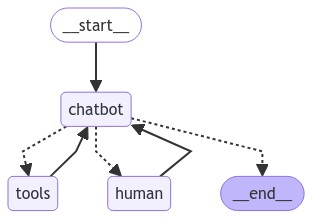

In [ ]:
# %%

from IPython.display import Image, display

try:
    display(Image(state_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# %%

config = {"configurable": {"thread_id": "1"}}
def ask_graph(user_input):
    # The config is the **second positional argument** to stream() or invoke()!
    events = state_graph.stream(
        {"messages": [("user", user_input)]}, {"configurable": {"thread_id": "1"}}, stream_mode="values"
    )
    messages_store = []
    for event in events:
        if "messages" in event:
            event["messages"][-1].pretty_print()
            messages_store.append(event["messages"][-1])

    return messages_store
user_input = "show all the node that the undersea cities node point to.That is return the node that undersea cities node have outward edges on it."

In [ ]:
#%%

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma
from langchain_openai import AzureOpenAIEmbeddings


# Initialize Azure OpenAI embeddings and load the contents of the file 'stage1.txt' into a Document object
# The Document object contains the text of the state of the union which is used to build the graph's index
# The Graphretriever is initialized with the state of the union text and the graph which is used to query the graph database
embd = AzureOpenAIEmbeddings()
with open('test1.txt', 'r') as f:
    file_content = f.read()

doc = [Document(page_content=file_content)]
graph_api = Graphretriever.from_docs( '',graph) # Initialize the graph API with the state of the union text and the graph

In [ ]:
# %%

# initialize the doc system
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(doc)

# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embd,
)
retriever = vectorstore.as_retriever()

In [ ]:
# %%

### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

In [ ]:
# %%

### Retrieval Grader


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "marval ironman"
docs = retriever.get_relevant_documents(question)
# doc_txt = docs[1].page_content

In [ ]:
# %%

### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

question = 'who is Paul?'
# Prompt
prompt = hub.pull("rlm/rag-prompt")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
# print(generation)

In [ ]:
# %%

### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
# hallucination_grader.invoke({"documents": docs, "generation": generation})

In [ ]:
# %%

### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
# answer_grader.invoke({"question": question, "generation": generation})

In [ ]:
# %%

### Answer Merger


# Data model
class GenerationMerger(BaseModel):
    """Merge the generation from rag and graph rag."""

    merged_content: str = Field(
        description="Merge the content from the RAG and the Graph RAG generation. You need to combine the similiar and the unique content of the two text  \n outputing a coherent text. You only need to output the merged content."
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GenerationMerger)

# Prompt
system = """You are a content merger merging the generation from rag and graph rag.Graph rag tend to hold more marco and long-term information. While RAG tends to hold mirco and short-term information.Try to usen the graph rag info for background and fill in the detail with rag.
if graph rag generation said there is no information, only generate text based on rag generation instead."""
merge_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Graph RAG generation: \n\n {graph_generation} \n\n RAG generation: {generation}"),
    ]
)

generation_merger = merge_prompt | structured_llm_grader

In [ ]:
# %%

### Question Re-writer

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
# question_rewriter.invoke({"question": question})

In [ ]:
# %%

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    merge_final : str 
    question: str
    generation: str
    graph_generation : str
    documents: List[str]
    retry: int

In [ ]:
# %%

from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}



def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}
def graph_generate(state):
    question = state["question"]
    documents = state["documents"]
    graph_generation = ask_graph(question)
    graph_generation = graph_generation[-1].content
    return {"graph_generation" : graph_generation,"documents": documents, "question": question}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question, 'retry': state['retry']}

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question , 'retry': state['retry'] + 1}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = tavily[0].invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    filtered_documents = state["documents"]
    generation = state["generation"]
    retry = state['retry']


    if not filtered_documents and retry < 1:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    elif retry == 1:
        print(f"---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION AFTER {retry} ATTEMPTS, End Session---")
        return "end_session"
    elif generation == '':
        print("---DECISION: GENERATE_GRAPH---")
        return 'generate_graph'
    else:
        # We have relevant documents and we have generated from graph, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
  

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )

    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [ ]:
# %% 

def merge_text(state):
    print('---MERGE TEXT---')
    generation = state["generation"]
    graph_generation = state['graph_generation']
    merge_final = state['merge_final']
    document = state['documents']

    merged_text = generation_merger.invoke({"graph_generation": graph_generation, "generation": generation})

    return {'retry':state['retry'],"merge_final": merged_text.merged_content , "graph_generation": graph_generation , 'generation' : generation}

In [ ]:
# %%

from langgraph.graph import END, StateGraph, START

adaptive_rag = StateGraph(GraphState)

# Define the nodes
adaptive_rag.add_node("web_search", web_search)  # web search
adaptive_rag.add_node("retrieve", retrieve)  # retrieve
adaptive_rag.add_node("grade_documents", grade_documents)  # grade documents
adaptive_rag.add_node("generate", generate)  # generatae
adaptive_rag.add_node("transform_query", transform_query)  # transform_query
adaptive_rag.add_node('graph_generate', graph_generate)
adaptive_rag.add_node('merge_text', merge_text)


# Build graph
adaptive_rag.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
adaptive_rag.add_edge("web_search", "generate")
adaptive_rag.add_edge("retrieve", "grade_documents")
adaptive_rag.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate_graph": 'graph_generate',
        'generate': 'generate',
        'end_session': END
    },
)
adaptive_rag.add_edge('graph_generate', 'generate')
adaptive_rag.add_edge("transform_query", "retrieve")
adaptive_rag.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": 'merge_text',
        "not useful": "transform_query",
    },
)
adaptive_rag.add_edge('merge_text', END)

# Compile
ada_rag_complied = adaptive_rag.compile()

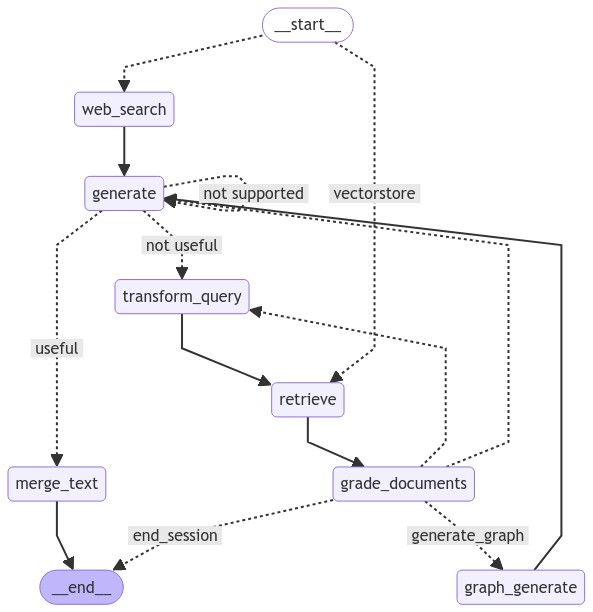

In [ ]:
# %%

from IPython.display import Image, display

try:
    display(Image(ada_rag_complied.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# %%

from pprint import pprint

inputs =  "base on the documents,what did human made in the future?"

def call_ada_rag_with_graph(user_input):
    user_inputs = {
    "question": user_input,
    'generation': '',
    'merge_final': '',
    'retry': 0
}
    output_store = None
    for output in ada_rag_complied.stream(user_inputs):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint("\n---\n")
        output_store = output
    return output

# temp_ata = call_ada_rag_with_graph(inputs)

In [ ]:
# %%

# pprint(temp_ata)

In [ ]:
# %%

def add_doc(path):
    with open(path) as f:
        content = f.read()
    doc.append(Document(page_content=content))
    graph_api.update_graph(content)
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(doc)

    # Add to vectorstore
    vectorstore = Chroma.from_documents(
        documents=doc_splits,
        collection_name="rag-chroma",
        embedding=embd,
    )
    return content

def add_doc_string(text):
    doc.append(Document(page_content=text))
    graph_api.update_graph(text)
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(doc)

    # Add to vectorstore
    vectorstore = Chroma.from_documents(
        documents=doc_splits,
        collection_name="rag-chroma",
        embedding=embd,
    )
    return text

In [ ]:
# %%

# Start from here, we have function ask graph and call_ada_rag_with_graph that
# let us do graph retrieval and do combined retrieval respectively.

In [ ]:
# %%

def reducer_append(old_list , new_string):
    print(f'{old_list=}')
    if new_string is not None:
        return old_list + [new_string]
    return old_list
class MainGraphState(TypedDict):
    world_setting : list
    user_input: list
    story_generation : list
    rag_generation : Annotated[list, reducer_append] 
    character_allocation : dict
    logic : list
    summary : list
    all_summary : str
    output : str

In [ ]:
# %%

def initizalize_graph_state_and_doc(state):
    """
    Initializes the graph state and document.

    This function takes in a state object and initializes the graph state by 
    extracting the world setting, character, narrator behavior, and previous 
    generation from the state. It then reads the all generation text from a file 
    and appends a document to the doc list. The function also updates the graph 
    using the graph API and splits the documents using a text splitter. Finally, 
    it adds the split documents to a vector store.

    Args:
        state (dict): The state object containing the graph state information.

    Returns:
        dict: An empty dictionary.
    """
    print('---initizalize_graph_state_and_doc---')
    world_setting = state['world_setting']
    previous_gen = None
    if state['story_generation'] != []:
        previous_gen = state['story_generation'][-1]
        print(f'{type(previous_gen)=}')
        print(f'{previous_gen=}')
        doc.append(Document(page_content=previous_gen))
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=500, chunk_overlap=0
        )
        doc_splits = text_splitter.split_documents(doc)
        add_doc_string(world_setting[-1])
        all_gen_text = '\n\n'.join(state['story_generation'])
        graph.query("MATCH (n) DETACH DELETE n")
        graph_api.update_graph(all_gen_text)
        vectorstore = Chroma.from_documents(
        documents=doc_splits,
        collection_name="rag-chroma",
        embedding=embd,
        )

    for ws in world_setting:
        graph_api.update_graph(ws)
    return {'world_setting': world_setting}

In [ ]:
# %%

# Prompt
system = """You are a quetion raiser who raise questions based on what is needed to answer the user given question. You questions need to be relevant to the user question.
Return your questions in json format and as many as you can. All questions need to be stored at 'questions' key.
"""
reflect_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question}. Your response in json need to have key questions."),
    ]
)

sub_question_chain = reflect_prompt | llm


question = "tell me a story that amy goes to deepsea adventure."

def ask_self_question(user_input):
    l_of_qs = json.loads(sub_question_chain.invoke({"question": user_input}).content)["questions"]
    return l_of_qs

In [ ]:
# %%

def get_relevant_info_from_docs(state):
    print('---get_relevant_info_from_docs---')
    user_input = state['user_input'][-1]
    l_of_q = []
    for i in range(3):
        try:
            l_of_q =ask_self_question(user_input)
            break
        except:
            continue
    relevant_info = []
    if l_of_q == []:
        graph_search = call_ada_rag_with_graph('Based on the document, '+user_input)
        if graph_search['retry'] <1:
            relevant_info.append(graph_search['merge_final'])
        else:
            relevant_info.append('')
    else:
        l_of_q.append(user_input)    
        for qs in l_of_q:
            graph_search = call_ada_rag_with_graph('Based on the document, '+qs)
            if graph_search['retry'] <1:
                relevant_info.append(graph_search['merge_final'])
            else:
                relevant_info.append('')
    print(f'{relevant_info=}')
    relevant_info_str = '||'.join(relevant_info)
    return {'rag_generation': relevant_info_str}

In [ ]:
# %%

class LogicChecker(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Later text contradict the earlier text? Answer 'yes: reason' or 'no: reason'."
    )


system = """You are a logical assistant who check if the later text content contradict the earlier text content.
Give a binary score with reason: 'yes : reason' or 'no : reason'. Yes' means that the later text contradict the earlier text. 
No means that the two text don't contradict each other. Also, change of place and time is allowed in two text.
"""
logic_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Earlier text: \n\n {text1}. Later text: \n\n {text2}."),
    ]
)

logic_chain = logic_prompt | llm


# text1 = "On monday. Mary is in the kitchen. Tom is in the bedroom."
# text2 = "On Tuesday.Tom is in the kitchen. Mary is in the bedroom."
# text1 = "On monday. Mary is a female. Tom is a male."
# text2 = "On Tuesday.Tom is a female. Mary is a male."
text1 = "Elephant 1 arrived"
text2 = "Elephant 2 arrived"
def check_two_texts(text1, text2):
    return logic_chain.invoke({"text1": text1, "text2": text2}).content

In [ ]:
# %%

def check_logic_generate(state):
    print('---check_logic_generate---')
    if state['story_generation'] == []:
        return {'logic': [True, [], []]}
    previous_gens = state['story_generation']
    logic = [True, [], []]
    for i in range(len(previous_gens)-1):
        text1 = previous_gens[i]
        text2 = previous_gens[-1]
        check_result = check_two_texts(text1, text2)
        if check_result[:3] == 'No:':
            logic[0] = False
            logic[1].append(i)
            logic[2].append(check_result[5:])
    print(f'{logic=}')
    return {'logic': logic}

In [ ]:
# %%

class CharacterTracker(BaseModel):
    """Binary score to assess answer addresses question."""

    grouping: str = Field(
        description="What is the grouping of the characters? e.g. 'group1 : Character1 , Character3' or 'group2 : Character2 , Character4'. Output in json format"
    )


system = """You are a character tracker who tracks the grouping of the characters based on the character location in the input text.
You output need to be in json format where groupi is the key. i is an integer. Name of charaters are the values in list.
"""
group_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Text: \n\n {text}."),
    ]
)

group_chain = group_prompt | llm


# text1 = "On monday. Mary is in the kitchen. Tom is in the bedroom."
# text2 = "On Tuesday.Tom is in the kitchen. Mary is in the bedroom."
# text1 = "On monday. Mary is a female. Tom is a male."
# text2 = "On Tuesday.Tom is a female. Mary is a male."
text = "In the heart of the Future Undersea Civilization, echoes of the past bubble up through the serene waters. Arial and Paul once thrived among the high-tech wonders, sharing dreams beneath the colossal transparent domes. The nostalgic hum of underwater transportation spoke their names. Luis and Jacob now walk the pathways they once charted, the memories of their friends lingering in the cool, aquatic air."
def check_group(text):
    return json.loads(group_chain.invoke({ "text": text}).content)

In [ ]:
#%%

def get_grouping(state):
    print('---get_grouping---')
    previous_gens = state['story_generation'][-1]
    character_allocation = state["character_allocation"]
    group = {}
    for i in range(3):
        try:
            group=check_group(previous_gens)
            break
        except:
            return {'character_allocation':character_allocation}
    character_pre_allocation = []
    chara_post_allocation = []
    for k, v in character_allocation.items():
        for c in v:
            character_pre_allocation.append((c, v.copy().remove(c)))
    for k,v in group.items():
        for c in v:
            chara_post_allocation.append(c)
    for c in character_pre_allocation:
        if c[0] not in chara_post_allocation:
            for k, v in group.items():
                breaked = False
                for sc in c[1]:
                    if sc in v:
                        v.append9(c[0])
                        break
                if breaked:
                    break
    print(f'{group=}')
    return {'character_allocation':group}

In [ ]:
# %%

system = """You are a summarizer who summarizes the input story stage.
"""
summarize_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Story stage: \n\n {text}."),
    ]
)

summarize_chain = summarize_prompt | llm


with open('stage1.txt', 'r') as f:
    user_input = f.read()

def summarize(user_input):
    summarized = summarize_chain.invoke({"text": user_input}).content
    return summarized

In [ ]:
# %%

def get_summary(state):
    print('---get_summary---')
    previous_gens = state['story_generation'][-1]
    summarized = summarize(previous_gens)
    all_sum = ''
    for i, sum in enumerate(state['summary']):
        all_sum += f'Stage{i}: \n'
        all_sum += sum
    all_sum  = summarize(all_sum)
    return {'summary': summarized, 'all_summary': all_sum}

In [ ]:
# %%

def merge_all(state):
    print('---merge_all---')
    rag_gen = state['rag_generation']
    char_allo = state['character_allocation']
    logic = state['logic']
    summary = state['all_summary']
    output = ''

    output += f'Information for next generatioin:\n {rag_gen} \n'
    output += f'Character allocation: \n {json.dumps(char_allo)} \n'
    output += f'Summary of what happened: \n {summary} \n'
    output += f'\n storyprogression should be slower, keep cohesive between history \n'
    return {'output': output}

In [ ]:
# %%

narrative_state_graph = StateGraph(MainGraphState)

narrative_state_graph.add_node('initlize', initizalize_graph_state_and_doc)
narrative_state_graph.add_node('get_info', get_relevant_info_from_docs)
narrative_state_graph.add_node('check_logic', check_logic_generate)
narrative_state_graph.add_node('group', get_grouping)
narrative_state_graph.add_node('summarize', get_summary)
narrative_state_graph.add_node('merge_all', merge_all)

narrative_state_graph.add_edge(START, "initlize")
narrative_state_graph.add_edge('initlize', "get_info")
narrative_state_graph.add_edge('get_info', "check_logic")
narrative_state_graph.add_edge('check_logic', "group")
narrative_state_graph.add_edge('group', "summarize")
narrative_state_graph.add_edge('summarize', "merge_all")
narrative_state_graph.add_edge('merge_all', END)
nar_complied = narrative_state_graph.compile()

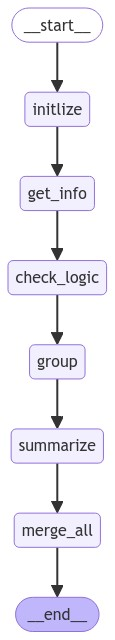

In [ ]:
# %%

from IPython.display import Image, display

try:
    display(Image(nar_complied.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# %%

def call_nar_graph(world_setting, user_input, story_generation,character_allocation, summary):
    user_inputs = {
        "world_setting": world_setting,
        "user_input": user_input,
        "story_generation": story_generation,
        "character_allocation": character_allocation,
        "summary": summary,
        'logic': [True, [], []],
    }
    output_store = None
    for output in nar_complied.stream(user_inputs, stream_mode= 'values'):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint("\n---\n")
        output_store = output
    return output_store

In [ ]:
# %%

# world_setting at least one, a list variable
ws = ['''

Humanity has developed an advanced undersea civilization in the future. Undersea cities have become the primary habitats for humans, featuring high-tech architecture and facilities, including transparent domes, underwater transportation systems, underwater agriculture, and energy development facilities.
''']
# user_input at least one, only use the last element of this list
ui = ['''
What humanity developed in the future?
''']
# story_generation at least one, a list variable, graph consider all the elements in this list
sg = ['''
The Divide of the Deep
In the vibrant undersea city of Aquapolis, two groups of friends pursued different paths, united by their love for the ocean but driven by distinct passions.

Arial and Paul formed a dynamic duo, combining science and engineering. One day, while exploring a newly mapped area near Aquapolis, they stumbled upon a cluster of unusual bioluminescent plants. Arial, excited by the potential for sustainable agriculture, gathered samples for study.

“This could revolutionize our underwater farms!” she said, her eyes sparkling.

Paul, surveying the surroundings, noted the intricate root systems. “We could design a system that integrates these plants into our existing infrastructure. Imagine the energy savings!”

As they worked, they noticed the plants thrived near a network of submerged caves. Curiosity piqued, they decided to investigate further, hoping to uncover more secrets of the ocean.

Meanwhile, Jacob and Luis embarked on their own adventure. Intrigued by the stories of the ancient civilization they had discovered, they aimed to share these tales with the community. Jacob envisioned a grand mural that depicted the rise and fall of the lost civilization, while Luis sought to research its history.

“We need to gather more artifacts and information,” Luis suggested. “This story could change how people view our connection to the ocean.”

Jacob nodded, sketching ideas for the mural. “Let’s explore the caves and find what we can. The visuals will be powerful!”
''']
# character_allocation, initize the character allocation, include all the characeter you want.
ca = {"group1":['Arial', 'Paul', 'Luis', 'Jacob']}
# summary, optional, input []
su = ['''Summary: The Divide of the Deep
In Aquapolis, Arial and Paul explore bioluminescent plants to enhance sustainable agriculture, while Jacob and Luis investigate artifacts from an ancient civilization. As both groups make discoveries, they realize their pursuits are interconnected, revealing lessons about environmental neglect.

They unite to share their findings at a community event, presenting innovative ideas for sustainability and Jacob’s mural depicting the ancient civilization’s rise and fall. Their collaboration inspires the citizens of Aquapolis, reinforcing the importance of living in harmony with the ocean and shaping a brighter future together.''']
nar_output = call_nar_graph(ws, ui, sg , ca , su)

"Node 'world_setting':"
"Node 'user_input':"
"Node 'story_generation':"
"Node 'rag_generation':"
"Node 'character_allocation':"
"Node 'logic':"
"Node 'summary':"
'\n---\n'
---initizalize_graph_state_and_doc---
type(previous_gen)=<class 'str'>
previous_gen='\nThe Divide of the Deep\nIn the vibrant undersea city of Aquapolis, two groups of friends pursued different paths, united by their love for the ocean but driven by distinct passions.\n\nArial and Paul formed a dynamic duo, combining science and engineering. One day, while exploring a newly mapped area near Aquapolis, they stumbled upon a cluster of unusual bioluminescent plants. Arial, excited by the potential for sustainable agriculture, gathered samples for study.\n\n“This could revolutionize our underwater farms!” she said, her eyes sparkling.\n\nPaul, surveying the surroundings, noted the intricate root systems. “We could design a system that integrates these plants into our existing infrastructure. Imagine the energy savings!”\

In [ ]:
# %%

pprint(nar_output)

{'all_summary': 'In Aquapolis, Arial and Paul work on enhancing sustainable '
                'agriculture with bioluminescent plants, while Jacob and Luis '
                'study artifacts from an ancient civilization. They discover '
                'their pursuits are connected, teaching them about '
                'environmental neglect. The groups collaborate, sharing their '
                'findings at a community event and presenting ideas for '
                "sustainability. Jacob's mural depicting the ancient "
                'civilization inspires the citizens, emphasizing the '
                'importance of living in harmony with the ocean for a better '
                'future.',
 'character_allocation': {'group1': ['Arial', 'Paul'],
                          'group2': ['Jacob', 'Luis']},
 'logic': [True, [], []],
 'output': 'Information for next generatioin:\n'
           " ['In the future, humanity has made technological advancements in "
           'the developmen